# Relax Inc. 

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.


### Load the data

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

sns.set_style('darkgrid')

In [2]:
file_path_usr_eng = './data/takehome_user_engagement.csv'
file_path_usr = './data/takehome_users.csv'

usr_eng_df = pd.read_csv(file_path_usr_eng, parse_dates=['time_stamp'])
usr_df = pd.read_csv(file_path_usr, encoding='latin1')

### Exploratory data analysis

In [3]:
# Get info from each DataFrame
# time_stamp has been assign as index
usr_eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


We do not see any NaN values and dtypes are what is expected.

In [4]:
usr_eng_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# Print total number of users
print(f"Total number of users:\t{len(usr_eng_df['user_id'].unique())}")

# How many times has a user logged in
logs_df = usr_eng_df.groupby(by=["user_id"], as_index=False)["time_stamp"].count()

# Users that have logged in three or more times
logs_df = logs_df[logs_df["time_stamp"] >= 3]
print(f"Users logged in >= 3 times: {logs_df.shape[0]}")

# # Assign user_id as index
# logs_df = logs_df.set_index("user_id")

# Verify there is not duplicated user_id's
print(f"Duplicated User IDs:\t{logs_df.index.duplicated().sum()}")

# Rename time_stamp column
logs_df.rename(columns={"time_stamp" : "logs"}, inplace=True)

logs_df.head()

Total number of users:	8823
Users logged in >= 3 times: 2248
Duplicated User IDs:	0


,user_id,logs
1,2,14
7,10,284
13,20,7
24,33,18
28,42,342


In [6]:
# Once we have the indices of users that have logged in >= 3 times
# days_freq_df = usr_eng_df[usr_eng_df["user_id"].isin(logs_df["user_id"])].copy()
days_freq_df = usr_eng_df.copy()

# Sort values
days_freq_df.sort_values(by=["user_id", "time_stamp"], inplace=True)

# Extract date only 
days_freq_df["time_stamp"] = days_freq_df["time_stamp"].dt.date

# Change time_stamp dtype to datetime
days_freq_df["time_stamp"] = pd.to_datetime(days_freq_df["time_stamp"])

# # Group by user_id and time_stamp to get all days that an user has logged in
# user_time_df = days_freq_df.groupby(by=["user_id", "time_stamp"]).count()

# # Sum number of visits for even-rolling-day periods
# user_time_df.apply(lambda x: pd.rol)

In [7]:
days_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.3 MB


In [8]:
# 7 days rolling window
days_freq_df =  days_freq_df.groupby(by="user_id", as_index=False).rolling("7D", on="time_stamp", min_periods=0).sum()

# Group by the maximum frequency per user
days_freq_df =  days_freq_df.groupby(by='user_id')[["visited"]].max()

# Label adopted users if visited 3 or more
days_freq_df["adopted"] = days_freq_df["visited"].apply(lambda x: 1 if x >= 3 else 0)

In [9]:
# Chech how manny users are considered "adopted"
days_freq_df["adopted"].value_counts().sort_index()

0    7221
1    1602
Name: adopted, dtype: int64

In [10]:
days_freq_df.sample(5)

,visited,adopted
user_id,,
8299,1.0,0
8760,7.0,1
9472,1.0,0
2941,1.0,0
10867,3.0,1


We now have all the user IDs with their respective "adopted" label. We proceed to EDA and data processing.

In [11]:
# Rename object_id column
usr_df.rename(columns={"object_id":"user_id"}, inplace=True)

# Reset index for merging
days_freq_df.reset_index()

# Merge DataFrames
adopted_df = usr_df.merge(right=days_freq_df, on="user_id", sort=True)
adopted_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0


In [12]:
adopted_df.describe()

,user_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted
count,8823.000000,8.823000e+03,8823.000000,8823.000000,8823.000000,4776.000000,8823.000000,8823.000000
mean,6019.821716,1.379279e+09,0.252295,0.151989,142.572254,5980.495394,1.866259,0.181571
std,3464.251001,1.953116e+07,0.434354,0.359031,124.176422,3394.211361,1.812267,0.385512
min,1.000000,1.338452e+09,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000
25%,3017.500000,1.363195e+09,0.000000,0.000000,30.000000,3071.000000,1.000000,0.000000
50%,6034.000000,1.382888e+09,0.000000,0.000000,109.000000,5947.000000,1.000000,0.000000
75%,9029.500000,1.398443e+09,1.000000,0.000000,239.000000,8857.250000,1.000000,0.000000
max,12000.000000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,7.000000,1.000000


In [13]:
# If user has been invited by another user add 1 else 0
adopted_df["invited_by_user"]  = adopted_df["invited_by_user_id"].apply(lambda x: 1 if x > 0 else 0)

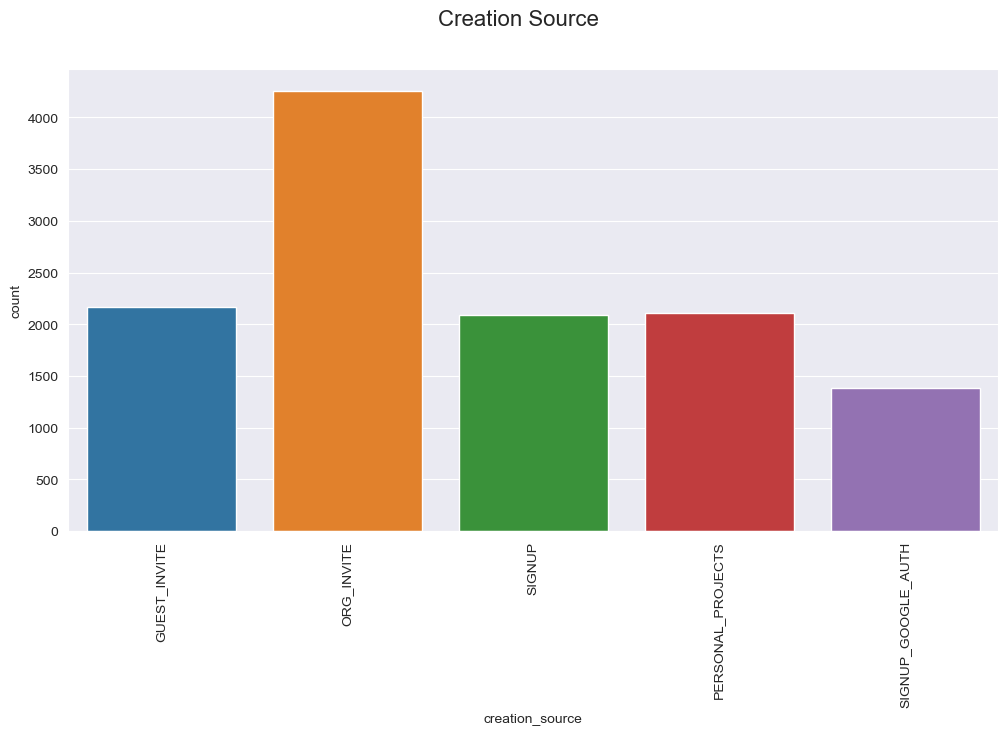

In [14]:
# Visualize different categories of creation_source
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=usr_df, x='creation_source', ax=ax)
ax.tick_params(axis='x', rotation=90)
fig.suptitle('Creation Source', fontsize=16)
plt.show()

We can see here that the majority of accounts were created by an invitation to an organization. 

In [15]:
import datetime
# sec = usr_df.loc[1,'last_session_creation_time']
# print(f'UNIX:\t{sec}')
# new_sec = datetime.datetime.utcfromtimestamp(sec)

# Transform UNIX timestamp of last login to datetime
adopted_df["last_session_creation_time"]  = adopted_df['last_session_creation_time'].apply(func=datetime.datetime.utcfromtimestamp)

In [16]:
# Check how many NaN values we have
adopted_df.isna().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time       0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            4047
visited                          0
adopted                          0
invited_by_user                  0
dtype: int64

In [17]:
adopted_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,1.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,3.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,1.0,0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,1.0,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,1.0,0,1


In [18]:
# Transform creation_time to datetime
adopted_df["creation_time"] = pd.to_datetime(adopted_df["creation_time"])

# Select categorical features
categorical_df = adopted_df.select_dtypes(include="object")
categorical_df.head()

,name,email,creation_source
0,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE
1,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE
2,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE
3,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE
4,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE


In [19]:
# count values for creation source
print(categorical_df["creation_source"].value_counts())

ORG_INVITE            3188
SIGNUP                1898
GUEST_INVITE          1588
SIGNUP_GOOGLE_AUTH    1385
PERSONAL_PROJECTS      764
Name: creation_source, dtype: int64


Preprocess categorical features to one-hot encode later.

In [20]:
# Get domain from email column
categorical_df["email_domain"] =  categorical_df["email"].str.split("@", expand=True).loc[:, 1]

# Get six more common email domains
common_e_domains = categorical_df["email_domain"].value_counts().sort_values(ascending=False).sort_values(ascending=False).index[:6].values

# Map emails not in common list to "other"
categorical_df["email_domain"] = categorical_df["email_domain"].apply(lambda x: x if x in common_e_domains else "other")

# Drop columns that we assume don't need
categorical_df.drop(columns=["name", "email"], inplace=True)

categorical_encoded_df = pd.get_dummies(categorical_df)

In [21]:
categorical_encoded_df.head()

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_domain_cuvox.de,email_domain_gmail.com,email_domain_gustr.com,email_domain_hotmail.com,email_domain_jourrapide.com,email_domain_other,email_domain_yahoo.com
0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,0,1


Preprocess numerical variables

In [22]:
# Extract numerical features
numerical_df = adopted_df.select_dtypes(exclude="object")

# Calculate days account has been open from creation to last login.
numerical_df["days_account_open"] = (numerical_df["last_session_creation_time"] - numerical_df["creation_time"]).dt.days

In [23]:
# Explore mailing list
numerical_df["opted_in_to_mailing_list"].value_counts()

0    6597
1    2226
Name: opted_in_to_mailing_list, dtype: int64

In [24]:
# Explore marketing drip
numerical_df["enabled_for_marketing_drip"].value_counts()

0    7482
1    1341
Name: enabled_for_marketing_drip, dtype: int64

In [25]:
# 
# numerical_df["org_id"].value_counts().sort_values(ascending=False).head(10)

In [26]:
# Extract numerical featerus to use for modelin
numerical_df = numerical_df[["opted_in_to_mailing_list", "enabled_for_marketing_drip", "visited", "adopted", "invited_by_user", "days_account_open"]]

# Change type of "visited"
numerical_df["visited"] = numerical_df["visited"].astype(int)

# Scale days_account_open
numerical_df["days_account_open"] = numerical_df["days_account_open"] / numerical_df["days_account_open"].max()

In [27]:
numerical_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,visited,adopted,invited_by_user,days_account_open
0,1,0,1,0,1,0.000000
1,0,0,3,1,1,0.186557
2,0,0,1,0,1,0.000000
3,0,0,1,0,1,0.001372
4,0,0,1,0,1,0.006859


In [28]:
# Merge both DataFrame
merged_df =  pd.concat([numerical_df, categorical_encoded_df], axis=1)

# Assign features to X and y
X = merged_df.drop(columns=["adopted"])
y = merged_df["adopted"]

# Split train and test set 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(f"X_train: {X_train.shape};\ty_train: {y_train.shape}")
print(f"X_test: {X_test.shape};\ty_test: {y_test.shape}")

X_train: (6176, 17);	y_train: (6176,)
X_test: (2647, 17);	y_test: (2647,)


In [29]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
opted_in_to_mailing_list,8823.0,0.252295,0.434354,0.0,0.0,0.000000,1.000000,1.0
enabled_for_marketing_drip,8823.0,0.151989,0.359031,0.0,0.0,0.000000,0.000000,1.0
visited,8823.0,1.866259,1.812267,1.0,1.0,1.000000,1.000000,7.0
adopted,8823.0,0.181571,0.385512,0.0,0.0,0.000000,0.000000,1.0
invited_by_user,8823.0,0.541312,0.498319,0.0,0.0,1.000000,1.000000,1.0
days_account_open,8823.0,0.081238,0.197767,0.0,0.0,0.001372,0.027435,1.0
creation_source_GUEST_INVITE,8823.0,0.179984,0.384196,0.0,0.0,0.000000,0.000000,1.0
creation_source_ORG_INVITE,8823.0,0.361328,0.480413,0.0,0.0,0.000000,1.000000,1.0
creation_source_PERSONAL_PROJECTS,8823.0,0.086592,0.281252,0.0,0.0,0.000000,0.000000,1.0
creation_source_SIGNUP,8823.0,0.215120,0.410929,0.0,0.0,0.000000,0.000000,1.0


Modeling

In [30]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(max_iter=10000)

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC(max_iter=10000)

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

# Performance evaluation of each binary classifier
accuracy, precision, recall = {}, {}, {}

# Loop through models
for key in models.keys():
    # Fit classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predictions = models[key].predict(X_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [31]:
# Create DataFrame with results
df_models = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_models['Accuracy'] = accuracy.values()
df_models['Precision'] = precision.values()
df_models['Recall'] = recall.values()
df_models.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall
Logistic Regression,1.000000,1.000000,1.000000
Support Vector Machines,1.000000,1.000000,1.000000
Decision Trees,1.000000,1.000000,1.000000
Random Forest,1.000000,1.000000,1.000000
K-Nearest Neighbor,0.997355,0.984881,1.000000
Naive Bayes,0.981488,1.000000,0.904297


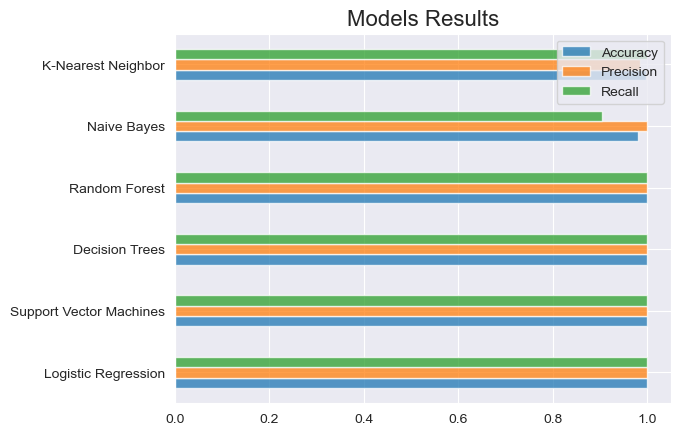

In [32]:
# Bar chart to compare the classifier's performance

ax = df_models.plot.barh(alpha=0.75)
plt.title('Models Results', fontsize=16)
plt.show()

In [33]:
importances = models['Random Forest'].feature_importances_
feature_names = X_train.columns.values
rand_forest_importances = pd.Series(importances, index=feature_names)
rand_forest_importances.sort_values(ascending=False)

visited                               0.626656
days_account_open                     0.367073
opted_in_to_mailing_list              0.000864
creation_source_GUEST_INVITE          0.000702
enabled_for_marketing_drip            0.000633
creation_source_SIGNUP                0.000464
email_domain_other                    0.000456
email_domain_hotmail.com              0.000446
email_domain_yahoo.com                0.000408
creation_source_PERSONAL_PROJECTS     0.000401
creation_source_ORG_INVITE            0.000338
invited_by_user                       0.000307
email_domain_gmail.com                0.000301
email_domain_gustr.com                0.000298
email_domain_jourrapide.com           0.000279
email_domain_cuvox.de                 0.000188
creation_source_SIGNUP_GOOGLE_AUTH    0.000186
dtype: float64